**Introduction Computer Vision**


*   For python implementation and some notes:
https://github.com/jalalirs/Introduction-to-Computer-Vision
*    For assignments, slides and course images:
https://github.com/yura/ud810
*    Answers to the problem sets using python:
https://github.com/gkouros/intro-to-cv-ud810 or:
https://github.com/thomasantony/ud810-intro-computer-vision


# 1. Introduction

## 	A. Introduction

### Lesson 01 (Introduction):
Intro the -state of the art- applications of CV and why CV is hard.

Slides: [PDF](https://s3.amazonaws.com/content.udacity-data.com/courses/ud810/slides/Unit-1/1A-L1.pdf)

# 2. Image Processing for Computer Vision

## A. Linear image processing

### Lesson 02 (Images as functions):
Dealing with Images as functions. You can add, subtract and multiply (by scalar) them. Gaussian Noise. NOTICE: The overflow when adding or the under flow when subtraction.

## Problem Set 0

### Lesson 03 (Filtering):
Image filtering and how we can remove noise by averaging with the near pixels. Which add some blurry effect. There is moving average filter and weighted moving average filter (Correlation filtering or Gaussian filter). 
NOTICE: the higher the Sigma(of the filter) is the wider the blurry filter is the less noise is going to be after averaging. There is another sigma which we multiply by (as a scalar function) which increase the noise in the image.  Also, the kernel or the mask is better to be Odd number (3x3 or 7x7 and so on).


### Lesson 04 (Linearity and convolution):
Linearity is defined by: 1. Additivity H(f1+f2) = H(f1) + H(f2) 2. Multiplicative scaling H(αf1) = αH(f1). And that what makes a linear filter. NOTICE: the linear filter could be added to the whole image or each pixel of it independently. The Impulse function flips the kernel totally (up-down and left-right). But the convolution doesn't flip the image.
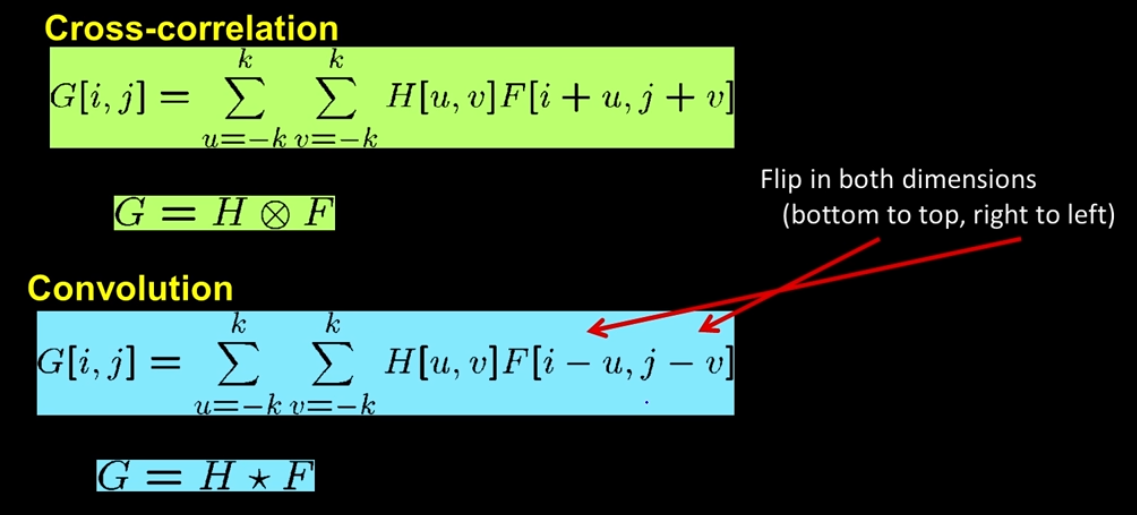
Convolutions Prosperities are: Linear, Shift invariant, commutative, Associate, Identity and Differentiation.
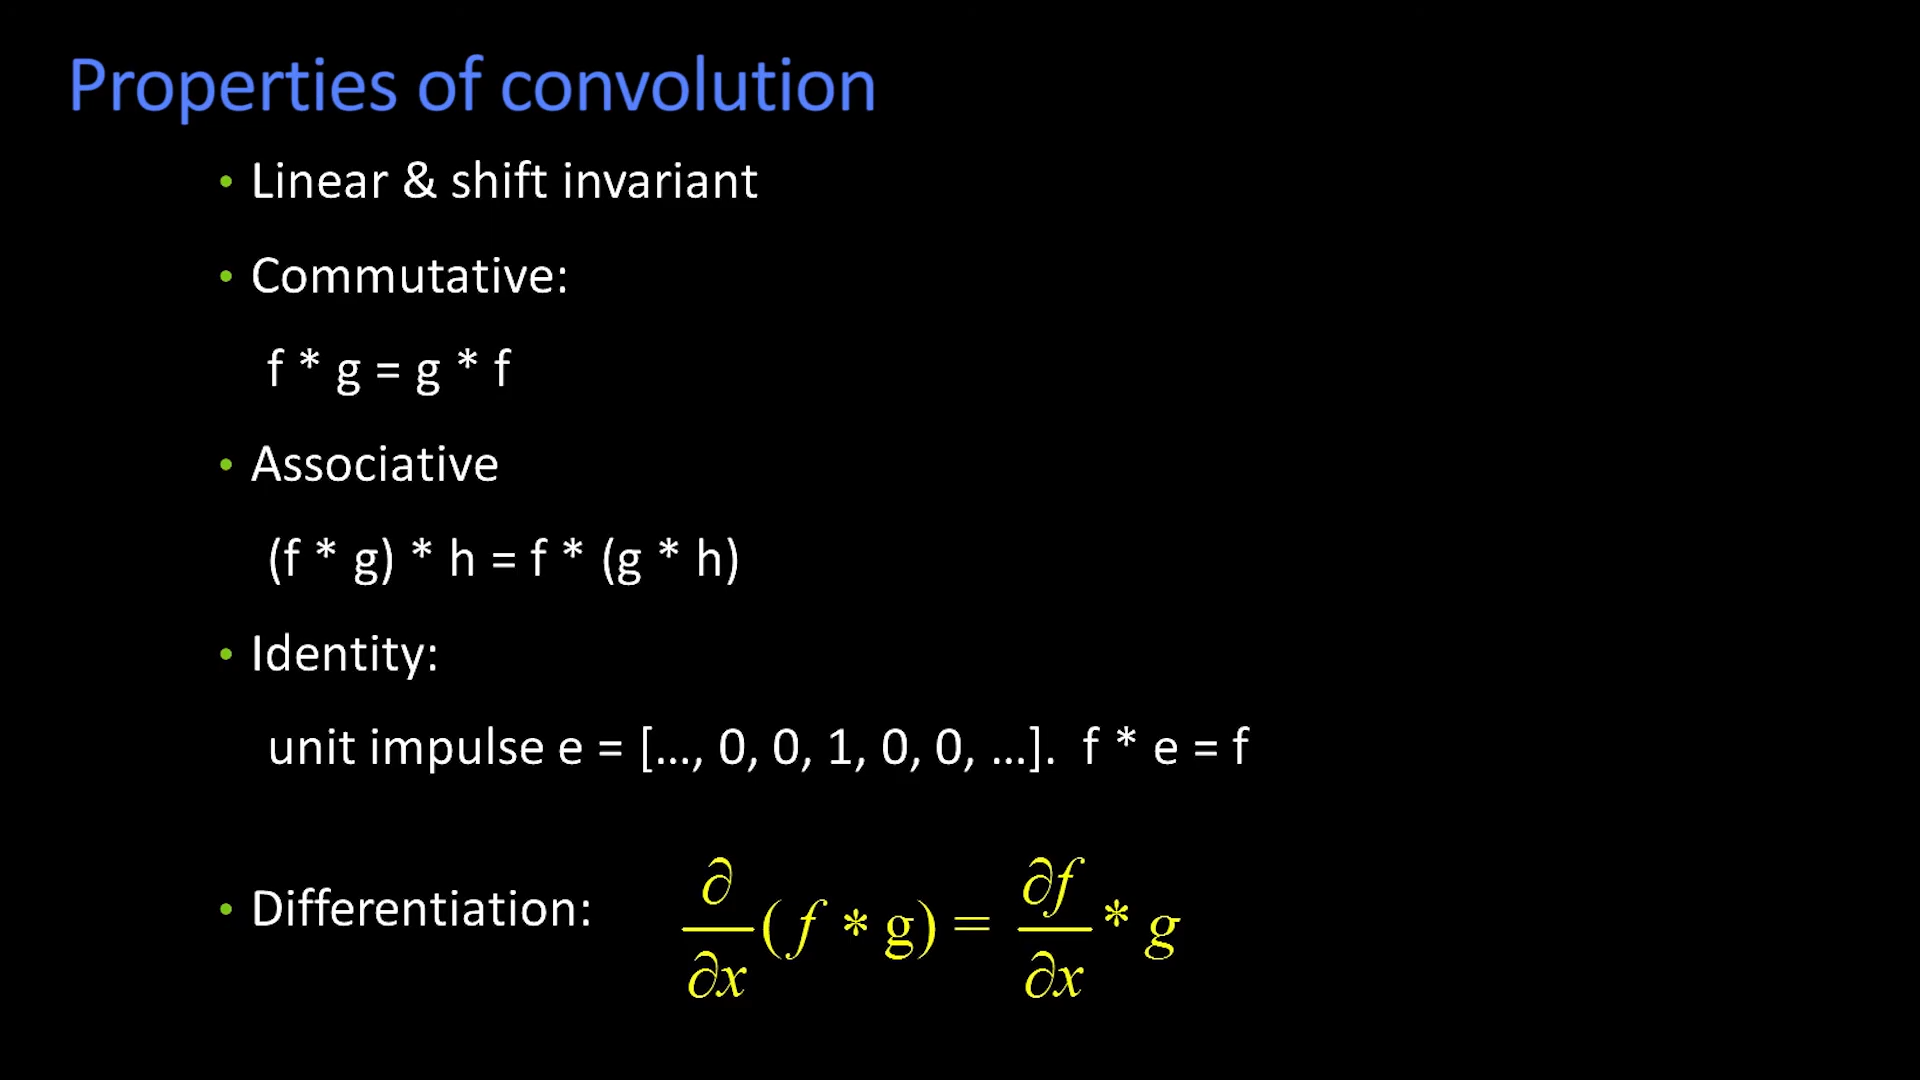
Linearly separable the kernel G = H * F = (C * R) * F = C * (R * F). Which reduce the Computational Complexity from N2xW2 to 2xNxW2. Boundary issues Methods: Clip filter (black), Wrap around, copy edge and reflect across edge. Median filter is not linear but it is good (no blurry) specially with pepper and salt filter (removing its effect) as it works as edge preserver.

### Lesson 05 (Filters as templates):
We use normalized correlation to find the similarity (between image and template) as the max value indicate the best match (doesn't have to be exactly the same -partially symmetric-).

### Lesson 06 (Edge detection: gradients):
An edge is a place of rapid change in the image intensity function. We can find edges using first derivatives (the peaks of derivative function). The gradient points in the direction of most rapid increase in intensity and the gradient vector magnitude is how much is it changing in that direction. Origin of Edges:

- surface normal discontinuity
- depth discontinuity
- surface color discontinuity
- illumination discontinuity

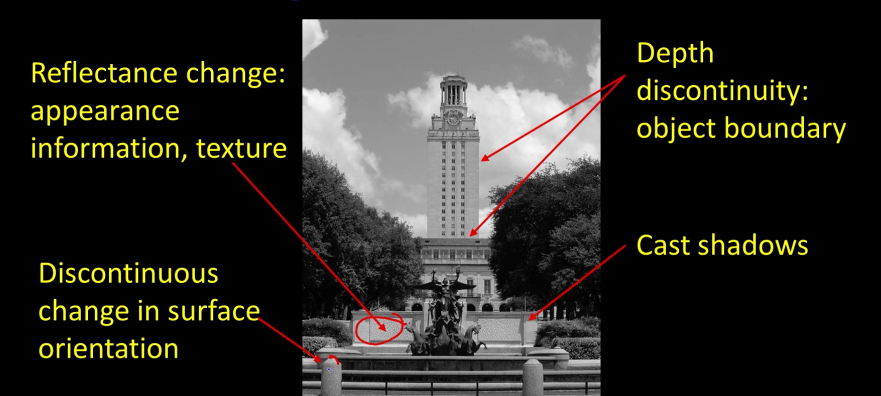

The gradient is zero of constant or at max or min of a slope. We use a 3x3 filter -or any other size- to calculate the gradient of X any Y each one independently. There is an average, Sobel, Prewitt and Roberts methods…
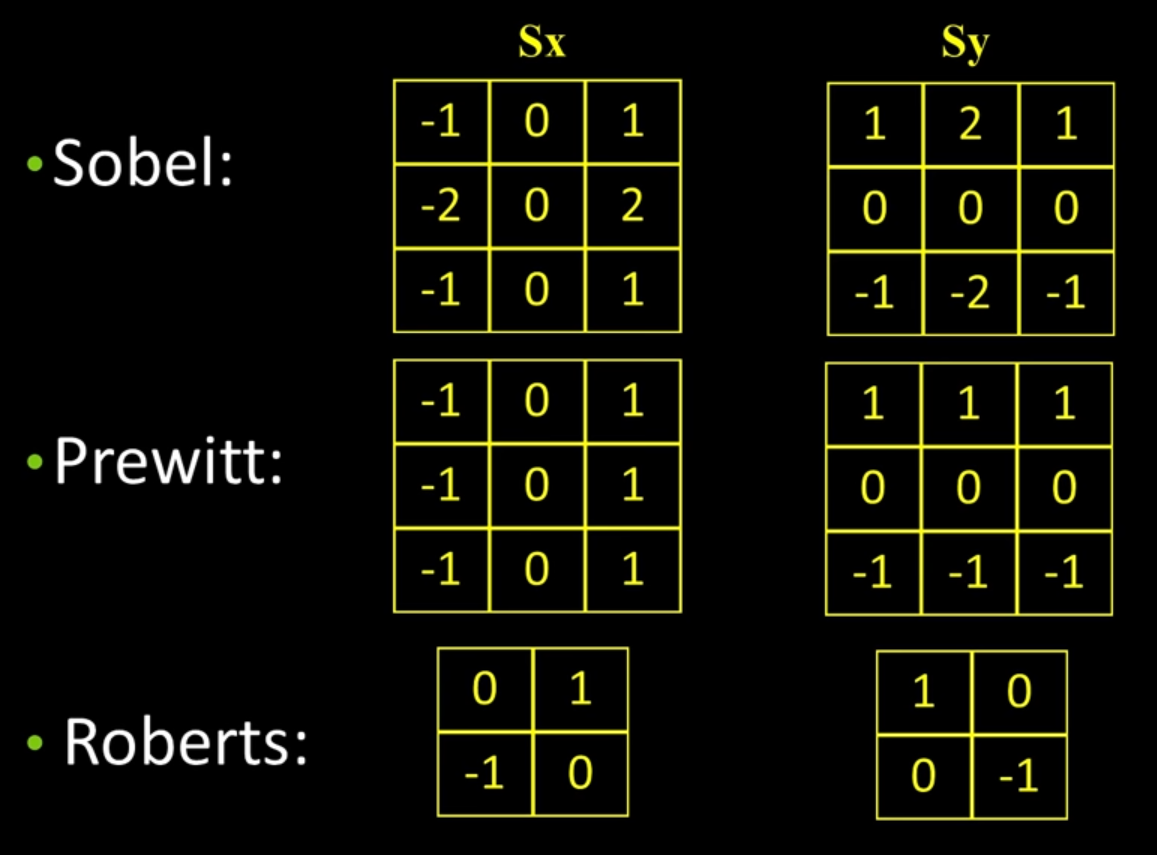
then we calculate the magnitude of the gradient of X,Y = (X2 + Y2)1/2. and the angle:
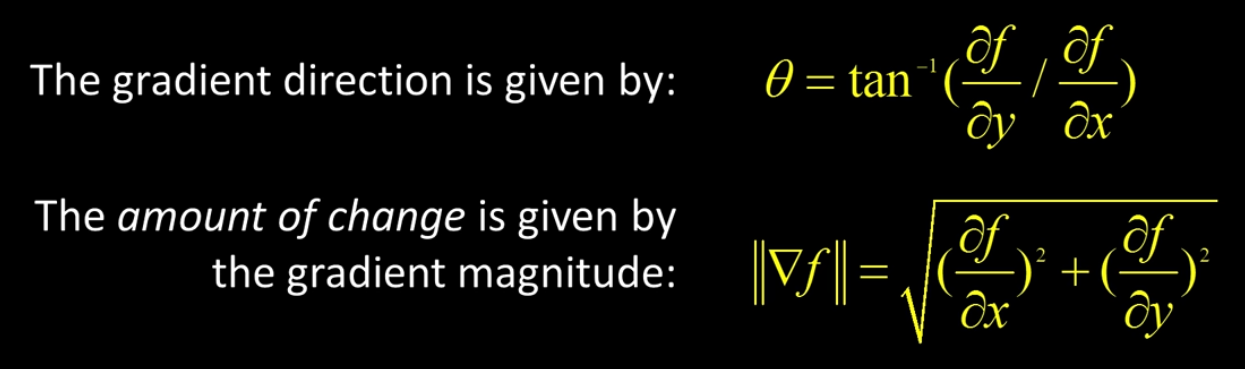
It doesn’t work in real world so we have to smooth the image at first. The second derivative finds the max peak which is the edge. NOTICE: we use the associate property so we use the derivative only on the filter then multiply it with image to smooth the image instead of doing derivative on the entire image (always the filter is smaller than the image) so now the filter is doing smoothing and finding the edges at the same time.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def rgb2gray(imgRGB):
  '''
  This function reads an 3-channels image and convert the image if needed to to grayscale(1-channel).
  
  Args:
    imgRGB: np.array() image with shape (width, height, 3).
  
  Retuens: 
    convert: np.array() image with shape (width, height).
  '''
  if len(imgRGB.shape)==3 and imgRGB.shape[2]==3:
    convert = np.dot(imgRGB[...,:3], [0.2989, 0.5870, 0.1140])
  else:
    convert = imgRGB
  return convert

def readImgClipped(imgPath, Gray=False):
  '''
  This function reads an image from a path and makes sure that the readen image is between 0(black) and 1(white).

  Args:
    imgPath: str path of an image.
    Gray: bool, if true convert RGB image to Gray.
  
  Retuens: 
    ImageRGB: np.array() image with shape (width, height, num channels) not clipped.
    Image: np.array() image Cliped either gray or RGB according to Gray variable value.
  '''
  ImageRGB = plt.imread(imgPath)
  Image = ImageRGB
  if Gray:
    Image = rgb2gray(ImageRGB)
  Image = Image/np.amax(Image)
  Image = np.clip(Image, 0, 1)
  return ImageRGB, Image

def imgShow(img, Gray=False):
  '''
  This function shows Gray images with the right min, max paramters.
  
  Args:
    img: np.array() image with shape (width, height).
    Gray: bool, if true show RGB image to Gray.
  '''
  if Gray:
    if img.max() <= 1 and img.min() >= 0:
      plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    else:
      plt.imshow(img, cmap='gray')
  else:
    plt.imshow(img)

In [7]:
def imgPadReflect(img, filter, verbose=False):
  img_rows, img_columns = img.shape
  filter_rows, filter_columns = filter.shape

  pad_h = int((filter_rows - 1) / 2)
  pad_w = int((filter_columns - 1) / 2)

  padded_image = img
  #up
  padded_rows, padded_columns = padded_image.shape
  padded_image = np.concatenate((np.flip(padded_image[:pad_h,:padded_columns],axis=0), padded_image), axis=0)
  #down
  padded_rows, padded_columns = padded_image.shape
  padded_image = np.concatenate((padded_image, np.flip(padded_image[padded_rows-pad_h:,:padded_columns],axis=0)), axis=0)
  #Left
  padded_rows, padded_columns = padded_image.shape
  padded_image = np.concatenate((np.flip(padded_image[:padded_rows,:pad_w],axis=1), padded_image), axis=1)
  #Right
  padded_rows, padded_columns = padded_image.shape
  padded_image = np.concatenate((padded_image, np.flip(padded_image[:padded_rows,padded_columns-pad_w:],axis=1)), axis=1)
  
  if verbose:
    imgShow(padded_image, Gray=True)
  return padded_image

In [8]:
def convolution2D(img, filter, XandY=True):
  """
  The kernels Gx and Gy can be thought of as a differential operation in the "input_image" array in the directions x and y 
  respectively. The default kernels are Sobel, represented by the following matrices:
  Gx =               
    | -1.0   0.0  1.0 |                 
    | -2.0   0.0  2.0 |                 
    | -1.0   0.0  1.0 |                                 
  Gy =
    |  1.0   2.0   1.0 |
    |  0.0   0.0   0.0 |
    | -1.0  -2.0  -1.0 |
  
  You can pass another kernel like Prewitt, Roberts.

  Args:
    img: np.array(), image with shape (width, height).
    filter: np.array(), Kernel/filter/operator.
    XandY: bool, to calculate both X and Y gradients and return them (XandY=True)or just one of them (XandY=False)

  Retuens: 
    xfilt: np.array() image with shape (width, height) of input img.
    yfilt: np.array() image with shape (width, height) of input img if XandY=True. (Optional)
  """

  # shape of img and filter
  img_rows, img_columns = img.shape  # we need to know the shape of the input grayscale image
  filter_rows, filter_columns = filter.shape  # we need to know the shape of the filter
  filter_abs_sum = np.sum(np.abs(filter)) # For normalization only

  # Here we define the matrices associated with the Sobel filter
  Gx = filter/(filter_abs_sum/2) # np.flip(filter, axis=1)
  if XandY:
    if filter_rows >= 3:
      Gy = np.flip(filter.T, axis=0)/(filter_abs_sum/2) #filter.T # np.flip(filter.T, axis=0)
    else:
      Gy = np.flip(filter, axis=1)/(filter_abs_sum/2) # flip over Y axis. the positive direction from bottom to top.
  
  xfilt = np.zeros(shape=(img_rows, img_columns))  # initialization of the X filter image (all elements are 0)
  if XandY:
    yfilt = np.zeros(shape=(img_rows, img_columns))  # initialization of the Y filter image (all elements are 0)

  padded_image = imgPadReflect(img, filter)

  # Now we "sweep" the image in both x and y directions and compute the output
  for row in range(img_rows):
    for column in range(img_columns):
      gx = np.sum(Gx * padded_image[row:row + filter_rows, column:column + filter_columns]) # x direction
      xfilt[row, column] = gx # Normalize(gx+filter_abs_sum/2) / (filter_abs_sum+filter_abs_sum/2)
      if XandY:
        gy = np.sum(Gy * padded_image[row:row + filter_rows, column:column + filter_columns]) # y direction
        yfilt[row, column] = gy #Normalize: (gy+filter_abs_sum/2) / (filter_abs_sum+filter_abs_sum/2)
  
  if XandY:
    returned_op = xfilt, yfilt
  else:
    returned_op = xfilt
  return returned_op

In [9]:
# ToDo: Continue functions Doc.

def dnorm(x, mu, sd):
  """
  Density of the normal distribution with mean equal to mu and standard deviation equation to sd
  
  Args:
    x: np.array(), array to be normalized.
    mu: np.array(), mean.
    sd: np.array(), standard deviation.

  Retuens: 
    xfilt: np.array() image with shape (width, height) of input img.
    yfilt: np.array() image with shape (width, height) of input img if XandY=True. (Optional)
  """
  return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_filter(size, mean=0, sigma=1):
  filter_1D = np.linspace(-(size // 2), size // 2, size)
  for i in range(size):
    filter_1D[i] = dnorm(filter_1D[i], mean, sigma)
  filter_2D = np.outer(filter_1D.T, filter_1D.T)
  filter_2D = filter_2D / 2
  return filter_2D

def gaussian_blur(img, filter_size, mean, sigma):
  filter = gaussian_filter(filter_size, mean, sigma)
  blurred = convolution2D(img, filter, XandY=False)
  return blurred

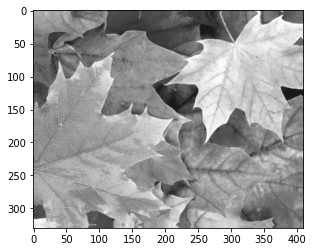

In [10]:
_,dddd = readImgClipped('/content/drive/MyDrive/Introduction to Computer Vision/Course Images/fall-leaves.png', True)
p = imgPadReflect(dddd, filter=gaussian_filter(11, mean=0, sigma=1), verbose=True)
# plt.imsave('pad.jpg',p)

In [11]:
def edge_detection(imgPath,
                   filter=np.array([[-1.0, 0.0, 1.0],[-2.0, 0.0, 2.0],[-1.0, 0.0, 1.0]]),
                   GaussianBlur_size=0, GaussianBlur_mean=0, GaussianBlur_sigma=0,
                   convert_to_degree=False, verbose=False):
  """
  The kernels Gx and Gy can be thought of as a differential operation in the "input_image" array in the directions x and y 
  respectively. The default kernels are Sobel, represented by the following matrices:
  Gx =               
    | -1.0   0.0   1.0 |                 
    | -2.0   0.0   2.0 |                 
    | -1.0   0.0   1.0 |                                 
  Gy =
    |  1.0   2.0   1.0 |
    |  0.0   0.0   0.0 |
    | -1.0  -2.0  -1.0 |
  
  You can pass another kernel like Prewitt, Roberts.

  Args:
    imgPath: np.array(), image with shape (width, height).
    filter: np.array(), Kernel/filter/operator.
    GaussianBlur_size: int, the filter size of gaussian filter to blur the image. if 0 no Gaussian Blur.
    GaussianBlur_mean: int, the mean of gaussian filter (default=0) 
    GaussianBlur_sigma: int, the Standard deviation of gaussian filter. if 0 then sigma = np.sqrt(GaussianBlur_size).\
                        NOTICE: sigma cant be 0 (divsion by zero. so, all values will be zero)
    convert_to_degree: bool, to convert the img_angle to degrees -if True- instead of radian. (default=False) 
    verbose: bool, to show the returned np.array() imgs -if true- or not (defalut=False)

  Retuens: 
    img_mag: np.array() image with shape (width, height) of input img, magnitude of X,Y gradients.
    img_angle: np.array() image with shape (width, height) of input img, direction of X,Y gradients.
  """
  # Read the image, cliped between 0 and 1 and convert it to Gray.
  input_image, grayscale_image = readImgClipped(imgPath, Gray=True)
  image = grayscale_image

  if GaussianBlur_size:
    if GaussianBlur_sigma == 0:
      GaussianBlur_sigma = np.sqrt(GaussianBlur_size)
    blurred_img = gaussian_blur(grayscale_image,
                                filter_size = GaussianBlur_size,
                                mean = GaussianBlur_mean,
                                sigma = GaussianBlur_sigma)
    image = blurred_img

  xfilt, yfilt = convolution2D(image, filter, XandY=True)

  img_mag = np.sqrt(np.square(xfilt) + np.square(yfilt))
  img_mag = img_mag * (255/img_mag.max())
  img_angle = np.arctan2(yfilt, xfilt)
  
  if convert_to_degree:
        img_angle = np.rad2deg(img_angle)
        # img_angle = img_angle + 180


  # Display the original image and the Sobel filtered image
  if verbose:
    if input_image.shape[1] > input_image.shape[0]:
      plt.figure(figsize=(15,15))
    else:
      plt.figure(figsize=(10,15))
    # Input Image
    plt.subplot(321)
    if len(input_image.shape)==3:
      imgShow(input_image)
    else:
      imgShow(input_image, Gray=True)
    plt.title('Input Image', size=14)
    # print(input_image.max(), input_image.min())
    plt.xticks([])
    plt.yticks([])
    # Blurred Image
    plt.subplot(322)
    imgShow(image, Gray=True)
    # print(image.max(), image.min())
    if GaussianBlur_size:
      plt.title('Gray Blurred Image', size=14)
    else:
      plt.title('Gray Image', size=14)
    plt.xticks([])
    plt.yticks([])
    # X Filter
    plt.subplot(323)
    imgShow(xfilt, Gray=True)
    # print(xfilt.max(), xfilt.min())
    plt.title('X Filter', size=14)
    plt.xticks([])
    plt.yticks([])
    # Y Filter
    plt.subplot(324)
    imgShow(yfilt, Gray=True)
    plt.title('Y Filter', size=14)
    plt.xticks([])
    plt.yticks([])
    # Final Filter mag
    plt.subplot(325)
    imgShow(img_mag, Gray=True)
    # print(img_mag.max(), img_mag.min())
    plt.title('Final Filter magnitude', size=14)
    plt.xticks([])
    plt.yticks([])
    # Final Filter angle
    plt.subplot(326)
    imgShow(img_angle, Gray=True)
    plt.title('Final Filter angle', size=14)
    plt.xticks([])
    plt.yticks([])
    plt.show()
  
  return img_mag, img_angle

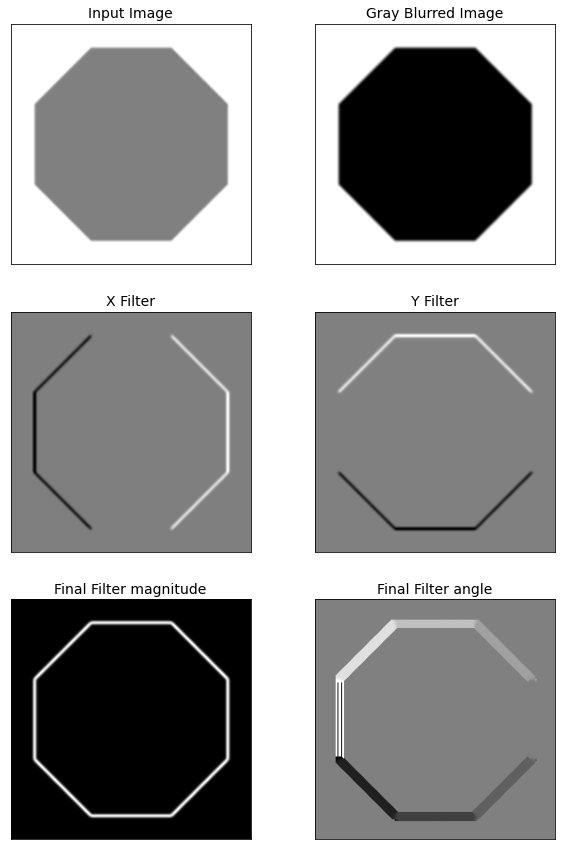

In [142]:
sobel_mag, sobel_angle = edge_detection('/content/drive/MyDrive/Introduction to Computer Vision/Course Images/octagon.png',
                                                          GaussianBlur_size=3, convert_to_degree=True,verbose=1)

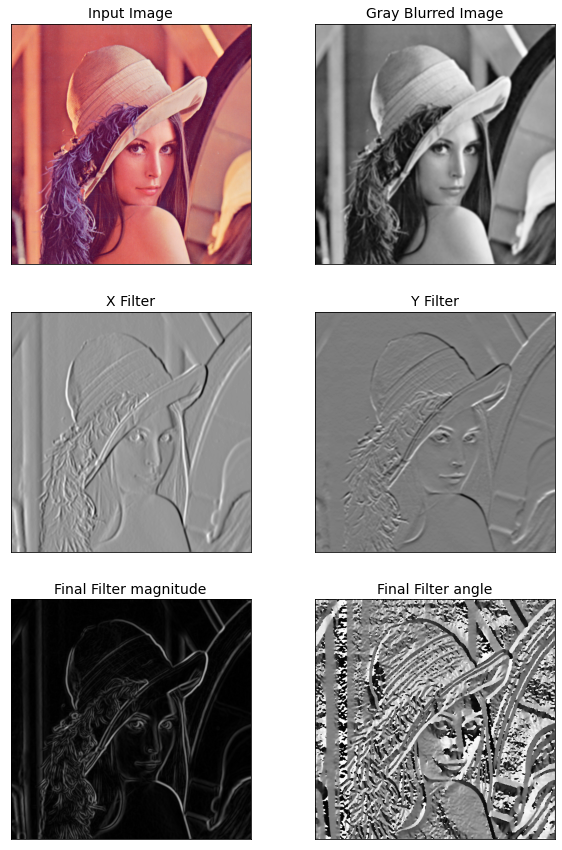

In [129]:
# Using Prewitt. a 3*3 operator.
mag, angle = edge_detection(imgPath='/content/drive/MyDrive/Introduction to Computer Vision/Course Images/lena.png',
                                    filter = np.array([[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]]), #Prewitt
                                    GaussianBlur_size=5, verbose=1)

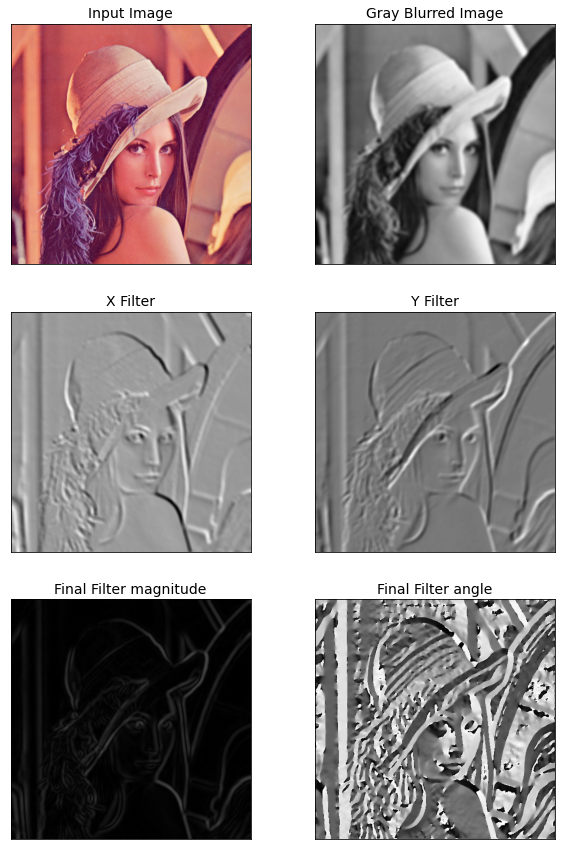

In [130]:
# Using Roberts. a 2*2 operator.
mag, angle = edge_detection(imgPath='/content/drive/MyDrive/Introduction to Computer Vision/Course Images/lena.png',
                                    filter = np.array([[0.0, 1.0], [-1.0, 0.0]]), #Roberts
                                    GaussianBlur_size=11, verbose=1)

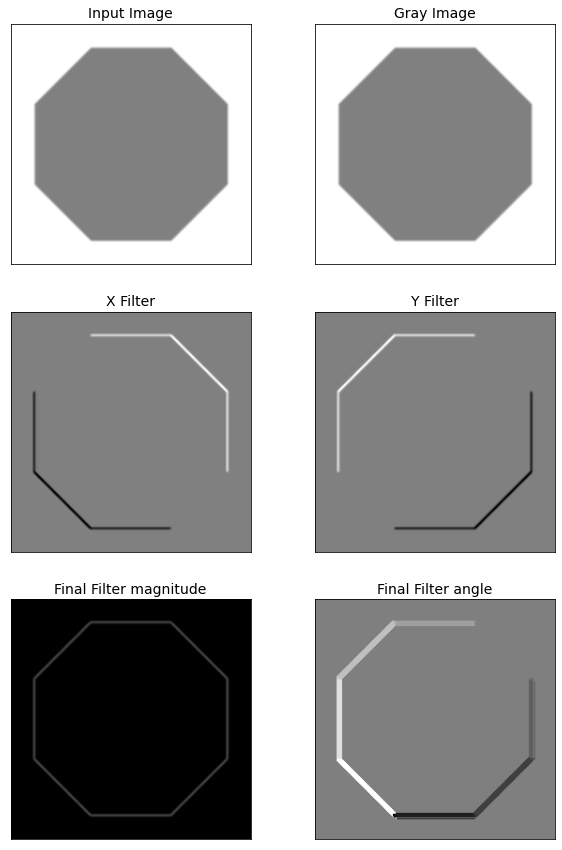

In [131]:
# Using Roberts. a 2*2 operator.
mag, angle = edge_detection(imgPath='/content/drive/MyDrive/Introduction to Computer Vision/Course Images/octagon.png',
                                    filter = np.array([[0.0, 1.0], [-1.0, 0.0]]), #Roberts
                                    GaussianBlur_size=0, verbose=1)

### Lesson 07 (Edge detection: 2D operators):
in 2D we do the same but the gradient direction is important. We use gradient of smooth filter (gaussian) and take the magnitude of the gradient then we do some thresholding then we do thinning. Thinning is a way of finding the edges that exceeds the threshold and convert it into edges. In addition to the 1D methods there is a canny method (which connects the higher threshold edges together and with a lower threshold edges -different threshold-). There is also a method called Laplacian Gaussian which calculate the second derivative in both direction -X,Y- and add them together.

smaller sigma more details of the image, larger sigma smother the image meaning less detalis

In [12]:
def non_max_suppression(gradient_magnitude, gradient_direction, verbose):
  image_row, image_col = gradient_magnitude.shape
  output = np.zeros(gradient_magnitude.shape)

  PI = 180
  for row in range(1, image_row - 1):
    for col in range(1, image_col - 1):
      direction = gradient_direction[row, col]

      # (0 - PI/8 and 15PI/8 - 2PI)
      if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
        before_pixel = gradient_magnitude[row, col - 1]
        after_pixel = gradient_magnitude[row, col + 1]
      elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
        before_pixel = gradient_magnitude[row + 1, col - 1]
        after_pixel = gradient_magnitude[row - 1, col + 1]
      elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
        before_pixel = gradient_magnitude[row - 1, col]
        after_pixel = gradient_magnitude[row + 1, col]
      else:
        before_pixel = gradient_magnitude[row - 1, col - 1]
        after_pixel = gradient_magnitude[row + 1, col + 1]

      if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
        output[row, col] = gradient_magnitude[row, col]

  if verbose:
    plt.figure(figsize=(8,8))
    plt.imshow(output, cmap='gray')
    plt.title("Non Max Suppression")
    plt.show()

  return output

In [13]:
def threshold(image, low=5, high=20, weak=50, verbose=False):
  output = np.zeros(image.shape)

  strong = 255

  strong_row, strong_col = np.where(image >= high)
  weak_row, weak_col = np.where((image <= high) & (image >= low))

  output[strong_row, strong_col] = strong
  output[weak_row, weak_col] = weak

  if verbose:
    plt.figure(figsize=(8,8))
    plt.imshow(output, cmap='gray')
    plt.title("threshold")
    plt.show()

  return output

In [14]:
def hysteresis(image, weak=50):
    image_row, image_col = image.shape

    top_to_bottom = image.copy()

    for row in range(1, image_row):
      for col in range(1, image_col):
        if top_to_bottom[row, col] == weak:
          if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
            row + 1, col] == 255 or top_to_bottom[
            row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
            row + 1, col + 1] == 255:
            top_to_bottom[row, col] = 255
          else:
            top_to_bottom[row, col] = 0

    bottom_to_top = image.copy()

    for row in range(image_row - 1, 0, -1):
      for col in range(image_col - 1, 0, -1):
        if bottom_to_top[row, col] == weak:
          if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
            row + 1, col] == 255 or bottom_to_top[
            row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
            row + 1, col + 1] == 255:
            bottom_to_top[row, col] = 255
        else:
          bottom_to_top[row, col] = 0

    right_to_left = image.copy()

    for row in range(1, image_row):
      for col in range(image_col - 1, 0, -1):
        if right_to_left[row, col] == weak:
          if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
            row + 1, col] == 255 or right_to_left[
            row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
            row + 1, col + 1] == 255:
            right_to_left[row, col] = 255
          else:
            right_to_left[row, col] = 0

    left_to_right = image.copy()

    for row in range(image_row - 1, 0, -1):
      for col in range(1, image_col):
        if left_to_right[row, col] == weak:
          if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
            row + 1, col] == 255 or left_to_right[
            row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
            row + 1, col + 1] == 255:
            left_to_right[row, col] = 255
          else:
            left_to_right[row, col] = 0

    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right

    final_image[final_image > 255] = 255

    return final_image

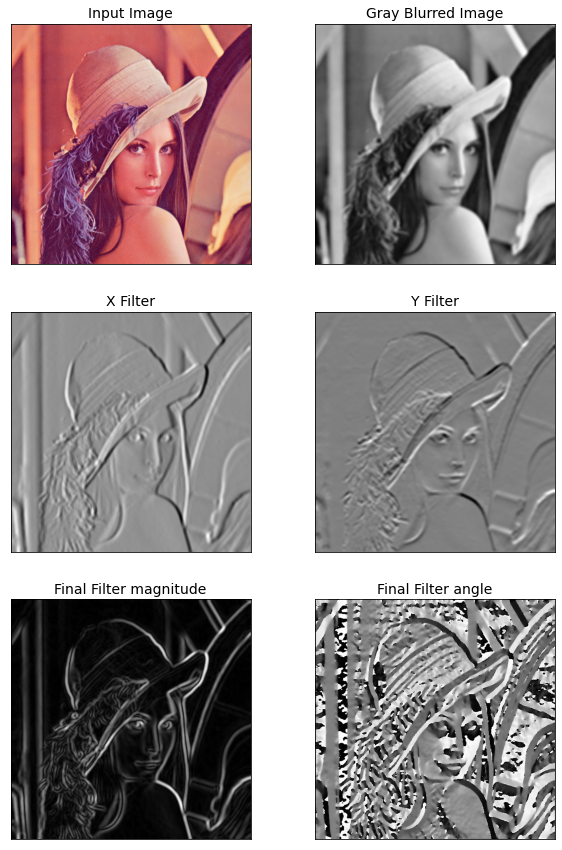

In [15]:
sobel_mag, sobel_angle = edge_detection('/content/drive/MyDrive/Introduction to Computer Vision/Course Images/lena.png',
                                                          GaussianBlur_size=9, convert_to_degree=True,verbose=1)

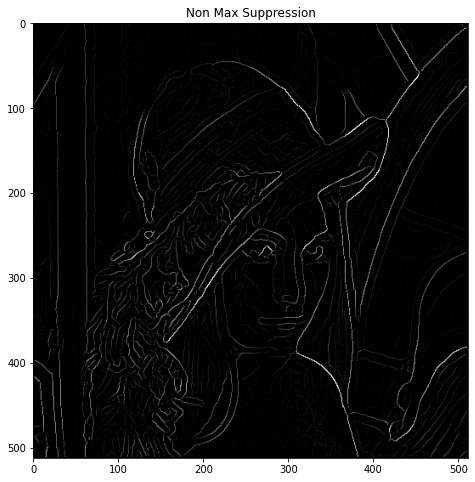

In [199]:
New = non_max_suppression(sobel_mag, sobel_angle, verbose=True)

In [200]:
weak = 100

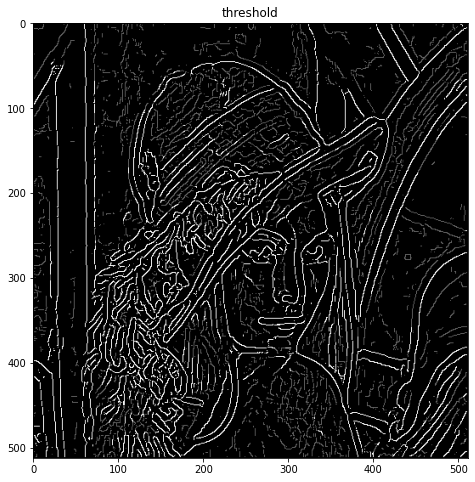

In [201]:
New = threshold(New, low=5, high=20, weak=weak, verbose=True)

Text(0.5, 1.0, 'Canny Edge Detector')

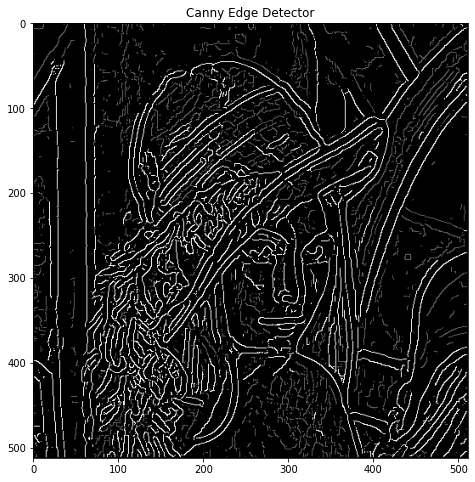

In [198]:
New = hysteresis(New, weak=weak)
plt.figure(figsize=(8,8))
plt.imshow(New, cmap='gray')
plt.title("Canny Edge Detector")

## B. Model fitting

### Lesson 08 (Hough transform: Lines):
Parametric model is an instant of a class defined by different values of different parameters. It is hard to get lines of an image as of Noise, Incompleteness of line in image and Extra Edge points (clutter). So we let data decide. So, we use voting: we let the features vote for all model that are compatible with. Hough transform is a voting technique. We can represent a line in X, Y space as a point in Hough m, b space and a point in X, Y space is a Line in Hough space. The intersection of lines in Hough is space denote the best line go through all points in X, Y space. Due to some restrictions in X, Y representation we instead use d, θ or the polar representation. Where d = xcos(θ) - ysin(θ) and we use Hough accumulator array to keep track of votes. There is three different extension Gradient of (X, Y) equals theta, change bin size and more votes for stronger edges.
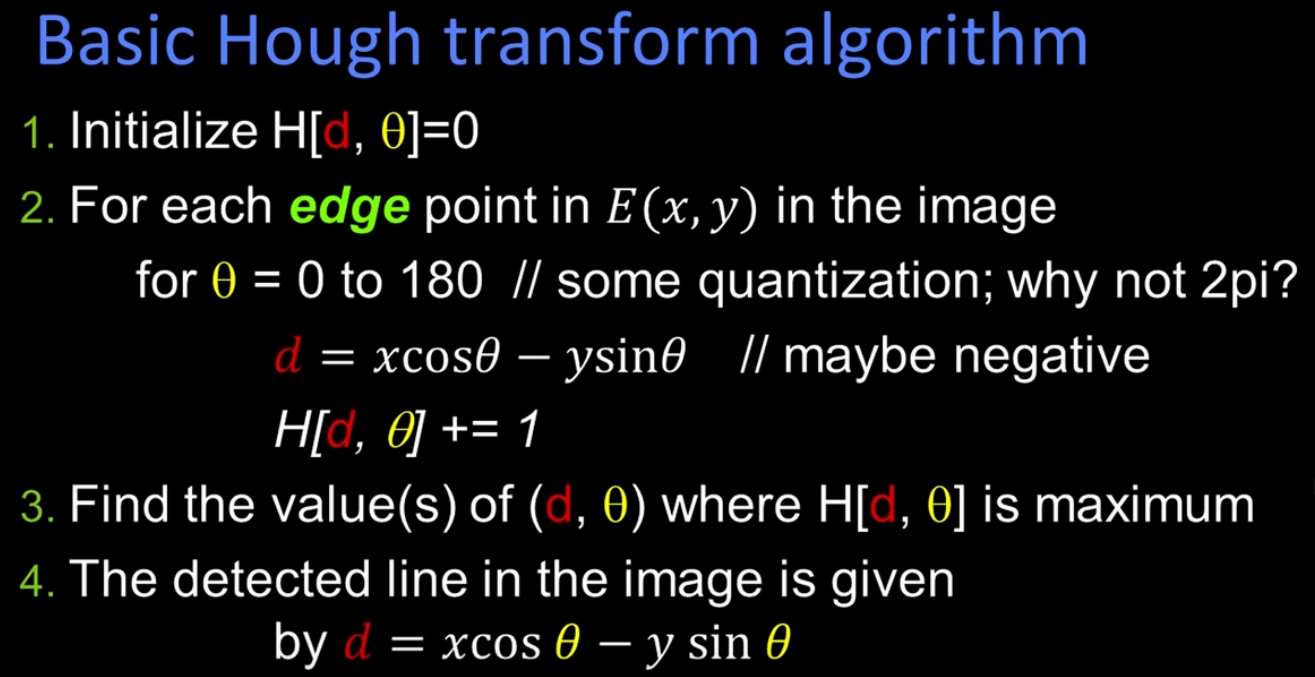

### Lesson 09 (Hough transform: Circles):
As with lines, the Hough space (a, b space or parameter space) for a point on a circle in (X, Y space) is a circle also with radius r. for unknown radius we use 3D -a, b, r- space and try different radius and it will draw a cone in 3D then you sum them up to get radius! Another way is use the gradient which will get you a line in the 3D space (easier and less calculations but still a problem as we working in 3D space). TIPS: Take edge points with significant gradient, Choose a good grid (coarse: many different lines votes for a single bucket vs. fine: some points of line vote for a different bucket), Vote for neighboring bins, Utilize direction of edge to reduce free parameters by 1 and keep track of points (edges) voted for the winning peaks. PROS: All points processed independently, Some robustness to noise and Detect multiple instances in a single pass. CONS: Complexity of search time, Non-targets shapes can produce peaks in parameter space and  Quantization it is hard to pick the grid size.

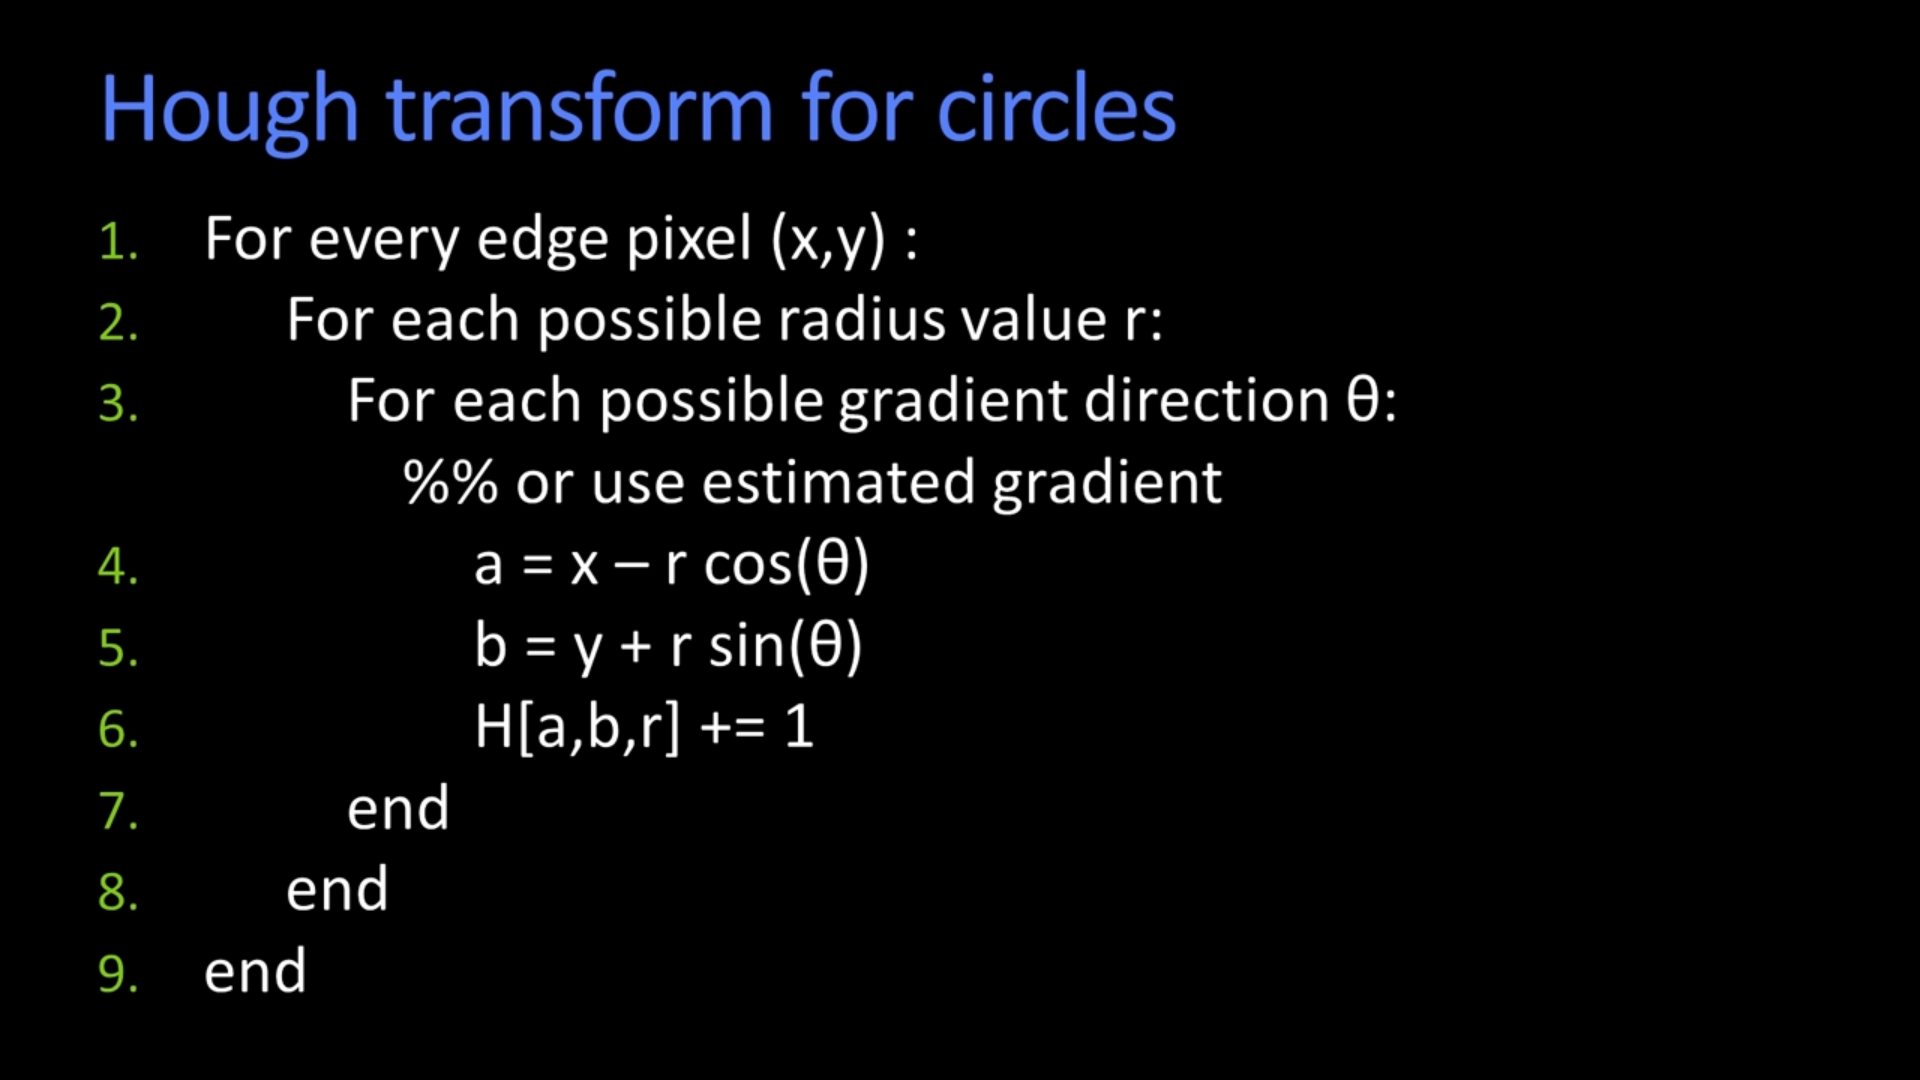

### Lesson 10 (Generalized Hough transform):
(add the algorithm slides) The idea is to store all the r's (the distance from edge point to the center and we decide the center) in table -called Hough table- indexed with gradient of θ. While trying on other image which may contain the same shape we try for each edge point and lookup in the Hough table of this shape for the same θ and draw r in both direction -if the direction is not known is not known- the most intersection of all r's of each edge point is voted the center of the shape. A more modern a robust way is working with features instead of edges. We store the feature in the Hough table and index it with gradient of θ -for example a tire of car can be used as a feature to detect a car-.

## Problem Set 1

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

(256, 256, 3)
(256, 256)


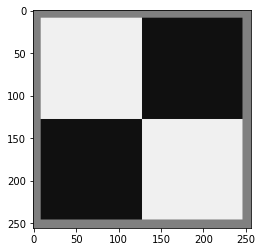

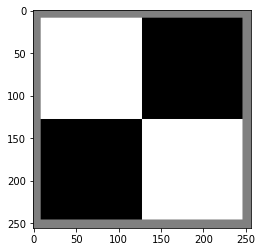

In [ ]:
im1 = cv2.imread('/content/input/ps1-input0.png')
print(im1.shape)
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
print(im1_gray.shape)
plt.imshow(im1)
plt.figure()
plt.imshow(im1_gray, cmap='gray')

## C. Frequency domain analysis

3. Camera Models and Views
A. Camera models
B. Stereo geometry
C. Camera calibration
D. Multiple views
4. Image FeaturesA. Feature detection
B. Feature descriptors
C. Model fitting
5. Lighting
A. Photometry
B. LightnessC. Shape from shading
6. Image MotionA. OverviewB. Optical flow
7. Tracking
A. Introduction to tracking
B. Parametric models
C. Non-parametric models
D. Tracking considerations
8. Classification and Recognition
A. Introduction to recognition
B. Classification: Generative models
C. Classification: Discriminative models
D. Action recognition
9. Useful Methods
A. Color spaces and segmentation
B. Binary morphology
C. 3D perception
10. Human Visual System
A. The retina
B. Vision in the brain